<a href="https://colab.research.google.com/github/Utomi-Tom/Semantic-Segmentation-of-Fractures/blob/main/3D_Fracture_and_clay_smear_segmentation_Permea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview

## Install Libraries

In [ ]:
!pip install segmentation-models-3D
!pip install efficientnet-3D
!pip install classification-models-3D;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 62 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install patchify;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import keras

# Import other libraries
import segmentation_models_3D as sm

from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as k

from sklearn.model_selection import train_test_split

Segmentation Models: using `tf.keras` framework.


In [ ]:
check = tf.test.is_gpu_available()
print(check)

True


## Dataset importation and overview

In [ ]:
from google.colab import files
files.upload()

Saving 3cm_offset.tif to 3cm_offset (1).tif


In [ ]:
!cp -r 3cm_offset_stack.tif  /content/drive/MyDrive/Permea_2

In [ ]:
!cp -r 3cm_offset_mask.tif /content/drive/MyDrive/Permea_2

In [ ]:
Stack = "/content/drive/MyDrive/Permea_2/3cm_offset_stack.tif"
Mask = "/content/drive/MyDrive/Permea_2/3cm_offset_mask.tif"

In [ ]:
image = io.imread(Stack)
mask = io.imread(Mask)

In [ ]:
image.shape, mask.shape

((256, 256, 256), (256, 256, 256))

In [ ]:
# Patchify the dataset
img_patch = patchify(image, patch_size=(64,64,64),
                     step=64)

mask_patch = patchify(mask,patch_size=(64,64,64), 
                      step= 64)

In [ ]:
img_patch.shape, mask_patch.shape

((4, 4, 4, 64, 64, 64), (4, 4, 4, 64, 64, 64))

([], <a list of 0 Text major ticklabel objects>)

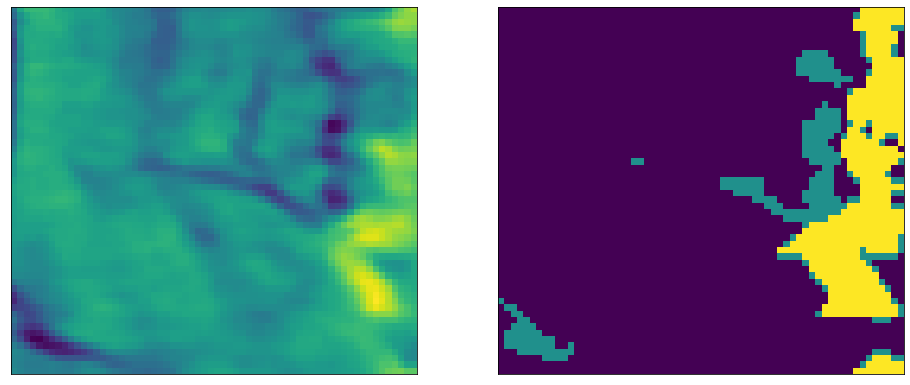

In [ ]:
plt.figure(figsize=(16,15))

plt.subplot(121)
plt.imshow(img_patch[3,1,2,2:60,:64,3])
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(mask_patch[3,1,2,2:60,:64,3])
plt.xticks([])
plt.yticks([])

In [ ]:
input_img = np.reshape(img_patch, (64, 64, 64, 64))
input_mask = np.reshape(mask_patch, (64,64,64,64))

In [ ]:
train_img = np.stack((input_img,)*3, axis=-1)
train_mask = (input_mask/255).astype("float32")

In [ ]:
train_mask= np.expand_dims(train_mask, axis=4 )

In [ ]:
train_mask= np.reshape(train_mask, (64, 64, 64, 64, 1))

In [ ]:
train_mask.shape

(64, 64, 64, 64, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical
mask_cat = to_categorical(train_mask, num_classes=4, )

In [ ]:
train_img.shape, mask_cat.shape

((64, 64, 64, 64, 3), (64, 64, 64, 64, 4))

In [ ]:
x_tr, x_test, y_tr, y_test = train_test_split(train_img, 
                                              mask_cat,
                                              test_size= 0.20,
                                              random_state=123)

In [ ]:
# Define model

encoder_weights = None
BACKBONE ='vgg16'
activation = "sigmoid"
patch_size = 64
channels = 3
LR = 0.0001


In [ ]:
optim = tf.keras.optimizers.Adam(LR)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [ ]:
preprocess = sm.get_preprocessing(BACKBONE)

In [ ]:
x_tr_p = preprocess(x_tr)
x_test_p = preprocess(x_test)

## Model building

In [ ]:
model = sm.Unet(BACKBONE, input_shape=(patch_size, patch_size,
                                       patch_size, channels),
                encoder_weights=None,activation=activation,
                classes= 4 )

In [ ]:
# compile the model
model.compile(optimizer=optim, loss =dice_loss, metrics= metrics)

In [ ]:
print(model.summary())

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding3d_64 (ZeroPadding  (None, 70, 70, 70,   0          ['input_14[0][0]']               
 3D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv3D)            (None, 32, 32, 32,   65856       ['zero_padding3d_64[0][0]']      
                                64)                                                        

In [ ]:
history = model.fit(x_tr_p, 
                    y_tr, 
                    batch_size=32,
                    epochs = 150, 
                    verbose =1,
                    validation_data=(x_test_p, y_test))

Epoch 1/150


ResourceExhaustedError: ignored

In [ ]:
model.save("/content/drive/MyDrive/Permea_2/no_weight_model7.h5")

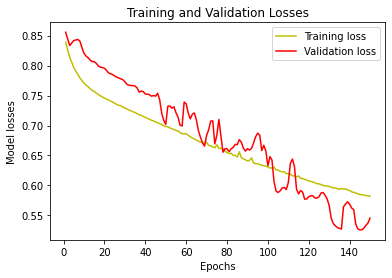

In [ ]:
# Plot the training and validation IoU and loss at each epoch 

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label= "Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Model losses")
plt.legend()
plt.show()


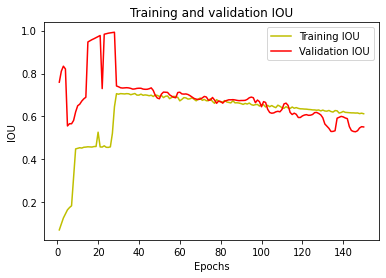

In [ ]:
acc = history.history["iou_score"]
val_acc = history.history["val_iou_score"]

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# Predict on test data

y_pred = model.predict(x_test_p)
y_pred_argmax = np.argmax(y_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis =2)

In [ ]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
len(np.unique(y_pred_argmax)/63)

(13, 64, 64, 4)
(13, 64, 64, 4)


64